# Nearest Neighbors Example

## Server's Data Setup
The server owns coordinates to points of interest like restaurants and commerces. The coordinates are kept in a LookupTable

In [1]:
from concrete import fhe
import numpy


# Database of Points of Interests
points_array = numpy.array([
    [2, 3], [1, 5], [3, 2], [5, 2], [1, 1],
    [9, 4], [13, 2], [14, 13], [9, 8], [8, 0],
    [2, 10], [3, 8], [8, 12], [4, 10], [7, 7],
])
N_PTS = points_array.shape[0]
points = fhe.LookupTable(points_array.flatten())


def get_point(index):
    return (points[2*index], points[2*index + 1])


def all_distances(x, y):
    xs = numpy.arange(0, 2 * N_PTS, 2)
    ys = numpy.arange(1, 2 * N_PTS, 2)
    a = abs(points[xs] - x)
    b = abs(points[ys] - y)
    return a + b

/home/riad/envs/zama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use swap sort to find the $K$ nearest points to a given point. However, we are interested in the indices of the elements, not just their distances. We must therefore work on tuples of index and distance, effectively implementing numpy argpartition.

In [2]:
# TLUs
relu = fhe.univariate(lambda x: x if x > 0 else 0)
is_positive = fhe.univariate(lambda x: 1 if x > 0 else 0)
odd_halving = fhe.univariate(lambda x: (x-1)//2 if x % 2 else 0)  

In [3]:
def swap(this_idx, this_dist, that_idx, that_dist):
    """
    Swaps this and that if this > that. 
    We must pass both the index and the distance for both this and that.

    Returns:
      idxmin, min, idxmax, max of this and that based on distance
    """
    diff = this_dist - that_dist
    idx = odd_halving(2 * (this_idx - that_idx) + is_positive(diff))
    dist = relu(diff)

    idx_min = this_idx - idx
    idx_max = that_idx + idx 
    dist_min = this_dist - dist
    dist_max = that_dist + dist
    return fhe.array([idx_min, dist_min, idx_max, dist_max])


@fhe.compiler({"x": "encrypted", "y": "encrypted"})
def knn(x, y):
    dist = all_distances(x, y)
    idx = list(range(N_PTS))
    for k in range(2):
        for i in range(k+1, N_PTS):
             idx[k], dist[k], idx[i], dist[i] = swap(idx[k], dist[k], idx[i], dist[i])
    return fhe.array([get_point(idx[j]) for j in range(2)])


inputset = [(4, 3), (0, 0), (15, 3), (4, 15), (9, 4), (13, 2), (14, 13), (9, 8), (8, 0), (2, 10), (3, 8), (8, 12), (4, 10), (7, 7)]

circuit = knn.compile(inputset)


## Client
The client simply invokes the server's nearest neighbors circuit.

In [4]:
%%timeit -r 1 -n 1
circuit.client.keys.generate()

4.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
def nearest(x, y):
    ex, ey = circuit.encrypt(x, y)
    res = circuit.run(ex, ey)   # Simulate request to the server
    return circuit.decrypt(res)

## Benchmarks

In [6]:
%%timeit -r 1 -n 1
nearest(4, 3)

9.08 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Note: Extended benchmark results can be found in README.MD

## Unitary tests

In [7]:
# unitary test of swap function
print("Suppose we have two values, this = 50 and that = 20, the swap function should swap the values and the indexes:")
this_idx = 0
this_dist = 50
that_idx = 10
that_dist = 20
this_idx, this_dist, that_idx, that_dist = swap(this_idx, this_dist, that_idx, that_dist)

print(f"New index of this is {this_idx}")
print(f"New value of this is {this_dist}")

print(f"New index of that is {that_idx}")
print(f"New value of that is {that_dist}")



print("Now if we have , this = 5 and that = 20, the swap function should keep everything unchanged:")
this_idx = 0
this_dist = 5
that_idx = 10
that_dist = 20
this_idx, this_dist, that_idx, that_dist = swap(this_idx, this_dist, that_idx, that_dist)

print(f"New index of this is {this_idx}")
print(f"New value of this is {this_dist}")

print(f"New index of that is {that_idx}")
print(f"New value of that is {that_dist}")

Suppose we have two values, this = 50 and that = 20, the swap function should swap the values and the indexes:
New index of this is 10
New value of this is 20
New index of that is 0
New value of that is 50
Now if we have , this = 5 and that = 20, the swap function should keep everything unchanged:
New index of this is 0
New value of this is 5
New index of that is 10
New value of that is 20


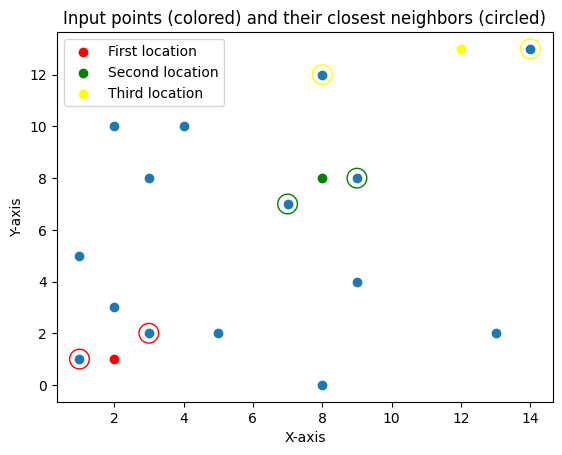

In [8]:
# unitary test of nearest function (which is indirectly testing knn function)
import matplotlib.pyplot as plt


x = [point[0] for point in points_array]
y = [point[1] for point in points_array]


first_location = [2, 1]
closest_to_first_location = nearest(first_location[0], first_location[1])

second_location = [8,8]
closest_to_second_location= nearest(second_location[0], second_location[1])

third_location = [12,13]
closest_to_third_location= nearest(third_location[0], third_location[1])


plt.scatter(x, y)


plt.scatter(first_location[0], first_location[1], color='red', label='First location')
plt.scatter(second_location[0], second_location[1], color='green', label='Second location')
plt.scatter(third_location[0], third_location[1], color='yellow', label='Third location')

for point in closest_to_first_location:
    plt.scatter(point[0], point[1], marker='o', facecolor='none', edgecolor='red', s=200)

for point in closest_to_second_location:
    plt.scatter(point[0], point[1], marker='o', facecolor='none', edgecolor='green', s=200)

for point in closest_to_third_location:
    plt.scatter(point[0], point[1], marker='o', facecolor='none', edgecolor='yellow', s=200)



plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Input points (colored) and their closest neighbors (circled)')
plt.legend()

plt.show()


The two functions knn and nearest achieve the same objective. The only difference is that nearest adds input encryption and output decryption to simulate a client-server communication. The tests below show that their results are similar.

In [9]:
assert (knn(first_location[0], first_location[1]) == nearest(first_location[0], first_location[1])).all()
assert (knn(second_location[0], second_location[1]) == nearest(second_location[0], second_location[1])).all()
assert (knn(third_location[0], third_location[1]) == nearest(third_location[0], third_location[1])).all()